In [1]:
import sys
from pathlib import Path

# add project root to Python path (so that the notebook can see src)
project_root = Path.cwd().parent
sys.path.append(str(project_root))
# sys.path
# ^ uncomment and run above line to verify it worked

# NVDA–SPX Risk & Dependence (Step-by-step)

We’ll build this project module-by-module.

Next: implement `src/nvda_spx/data.py` to download prices and compute returns.


In [2]:
# quick test to make sure data.py is working

from src.nvda_spx.data import download_prices, compute_returns

prices = download_prices("^GSPC", "NVDA", "2018-01-01")
prices.head()

Ticker,NVDA,SPX
Date,,
2018-01-02,4.928533,2695.810059
2018-01-03,5.252899,2713.060059
2018-01-04,5.280590,2723.989990
2018-01-05,5.325337,2743.149902
2018-01-08,5.488510,2747.709961


In [3]:
rets = compute_returns(prices)
prices.shape, rets.shape, rets.head()

((2024, 2),
 (2023, 2),
 Ticker          NVDA       SPX
 Date                          
 2018-01-03  0.065814  0.006399
 2018-01-04  0.005272  0.004029
 2018-01-05  0.008474  0.007034
 2018-01-08  0.030641  0.001662
 2018-01-09 -0.000270  0.001303)

In [4]:
# testing ex_nvda_return

from src.nvda_spx.data import download_prices, compute_returns
from src.nvda_spx.ex_nvda import ex_nvda_return

prices = download_prices("^GSPC", "NVDA", "2018-01-01")
rets = compute_returns(prices)

w = 0.07  # placeholder
ex = ex_nvda_return(rets["SPX"], rets["NVDA"], w)

rets.join(ex).head()

,NVDA,SPX,SPX_exNVDA
Date,,,
2018-01-03,0.065814,0.006399,0.001927
2018-01-04,0.005271,0.004029,0.003935
2018-01-05,0.008474,0.007034,0.006925
2018-01-08,0.030640,0.001662,-0.000519
2018-01-09,-0.000270,0.001303,0.001421


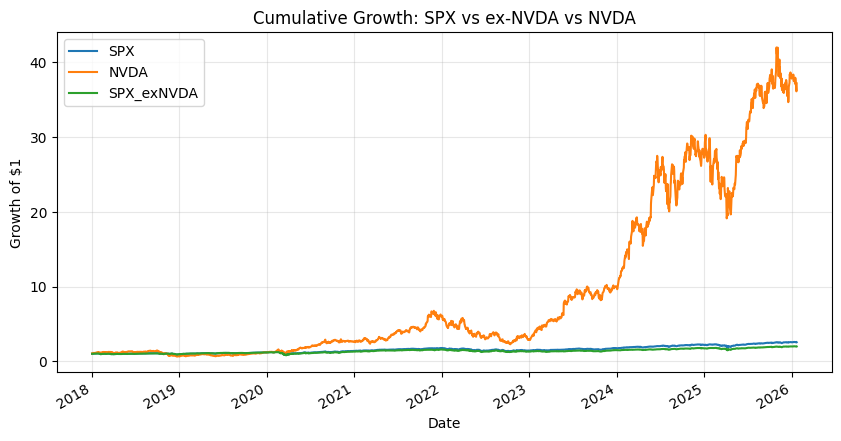

In [5]:
# testing plot_cumulative (on placeholder weight)

from src.nvda_spx.data import download_prices, compute_returns
from src.nvda_spx.ex_nvda import ex_nvda_return
from src.nvda_spx.plotting import plot_cumulative

prices = download_prices("^GSPC", "NVDA", "2018-01-01")
rets = compute_returns(prices)

w = 0.07
ex = ex_nvda_return(rets["SPX"], rets["NVDA"], w)

to_plot = rets[["SPX", "NVDA"]].join(ex)
plot_cumulative(to_plot, title="Cumulative Growth: SPX vs ex-NVDA vs NVDA");

The plot above is telling us that a dollar invested in SPX in 2018 corresponds to about \~3x return in eight years, but in the same time period, that same dollar in NVDA sees almost 40x return. Using the formula $R_a = (1 + R_c)^{1/n} - 1$, we see that NVDA's 2018-2026 return corresponds to **~60% annualized returns** (at peak periods) compared to just under 20% for SPX. Behavior this far out of line with normal equity returns is highly rare, but perhaps not all that unusual for a single stock undergoing a technological paradigm shift, especially when preceded by COVID supply disruptions and exploding demand (lots of people were at home playing video games, after all).

It should be noted as well that 20% annualized returns in eight years is not bad for a post-2010 bull market. As such, we should not emotionally take away the idea that SPX was doing poorly in this period, but rather that NVDA is undergoing unprecedented rapid growth. This by itself is not news, but what is interesting is that `SPX_exNVDA` is underneath but very close to `SPX`, even in late 2025 when NVDA returns have (so far) reached their peak cumulative growth in this time period. This tells us something important: removing NVDA *does not collapse the SPX index*. This could perhaps suggest it is more accurate to call NVDA a systemic market dependency than a bubble stock, but that's not evidence on its own, so let's dig deeper.

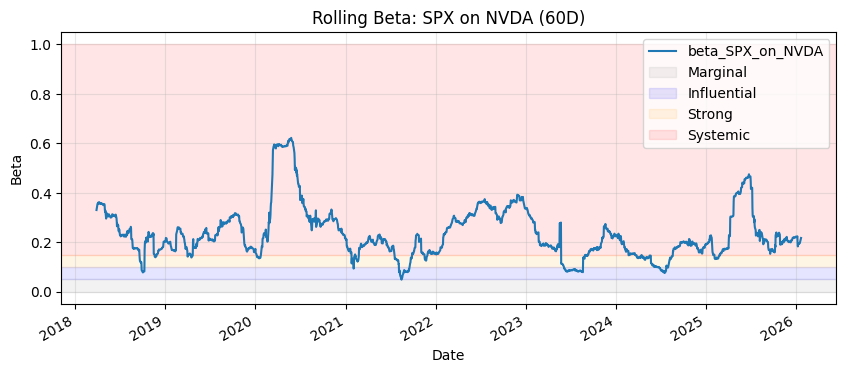

In [6]:
from src.nvda_spx.plotting import plot_rolling_beta

plot_rolling_beta(
    rets["SPX"],
    rets["NVDA"],
    window=60,
    title="Rolling Beta: SPX on NVDA (60D)",
);

This is a *rolling beta plot* of SPX on NVDA, which measures (over a given window of 60 trading days) how much we expect SPX to move per "unit of movement" (1% increase in returns) in NVDA. Naturally, if NVDA and SPX are highly correlated, they should both move by analogous movements over the same or similar time periods. Thus, I have added regions to the plot to add context to the values of beta:

* If $0 < \beta < 0.05$, then NVDA's influence on SPX is *marginal*. It is denoted by a **gray** region.
* If $0.05 < \beta < 0.1$, then NVDA's influence on SPX is *moderate* (or "influential", per my legend). It is denoted by a **blue** region.
* If $0.1 < \beta < 0.15$, then NVDA's influence on SPX is *strong*. It is denoted by an **orange** region.
* If $\beta > 0.15$, then NVDA's influence on SPX is *systemic*. It is denoted by a **red** region.

It is easy to see, then, that the betas for SPX on NVDA spend the vast majority of the time well into the systemic region, which certainly adds to the growing body of evidence that SPX is perhaps uncomfortably dependent on the performance of NVDA. However, there are a few surprising observations to point out here. In (my opinion) rough order of importance:

* The maximum value attained by the 60-day betas is just over **0.6** (!!). However, this occurred *in the early stages of the pandemic*, ***NOT*** anywhere during what one might call the "peak AI craze", or "that time NVDA became a bubble stock". This seems somewhat surprising at first, but remember that COVID resulted in a system shock to the economy, which tends to compress correlations in stock prices. Under stress, NVDA behaves like a market proxy, but this is perhaps not all that unusual for that specific time period; it may be worth checking this with other tech stocks in subsequent analysis. Nevertheless, the 60-day betas remain elevated for some time afterward, suggesting the pandemic may have increased NVDA's systemic coupling with the economy at least temporarily.
* There is a secondary peak in the rolling betas in mid-2025 that comes in at around **0.45** or so. This is also very high, but notably not as much as the pandemic peak, nor does it maintain that peak for as much time. It also seems somewhat sudden compared to the much slower but steadier increase throughout 2022 that ultimately fails to break 0.4. This could perhaps be caused by early reports of NVDA's [circular tech investments](https://finance.yahoo.com/news/nvidias-24b-ai-deal-blitz-has-wall-street-asking-questions-about-murky-circular-investments-110039309.html) between itself, tech companies, and data center companies, but it's hard to tell. In any case, there is evidence that the AI boom raised NVDA's return contribution relative to the rest of SPX, so it could perhaps be accurate to say that the pandemic "kicked off" a systemic coupling and the AI boom has merely reinforced it.
* On the other hand, the 60-day betas are surprisingly strong even *before* the pandemic, so while it's possible that both COVID and the AI boom had strong impacts on NVDA's relationship with the broader economy, it's likely that the uniqueness of NVDA as a company would cause one to reevaluate what a "typical" beta between NVDA and SPX should look like. That being said, the 60-day betas spend most of the 2018-2020 period hovering at around 0.2 or so, which is considered "systemic" by my plot but only just, whereas for many extended periods thereafter, the betas are well above 0.3 and even 0.4.
* The betas are very volatile, but often experience mean reversion (back to ~0.2 as mentioned earlier) with many peaks and valleys over the last eight years. This is perhaps an artifact of the relatively small window size (60 trading days is about three trading months), but that does not mean it's not useful; this is telling us that NVDA's relationship with SPX changes meaningfully, for various reasons, in relatively short time periods, and so its effect on SPX is thus *episodically* dominant.
* There is arguably not enough data to be truly confident about this, especially since the market has been surprisingly resilient over the last eight years in the face of wide global political uncertainty, but there appears to be possible asymmetry between beta behavior in booms versus crashes. That is to say, periods of sudden beta spikes seem like they could possibly correlate with sudden market stress, whereas its behavior (in either direction) appears to be more stable during market rallies. This suggests downside risk concentration, which means losses in SPX could be amplified by hypothetical losses in NVDA.

In view of that last point in particular, one wonders what might happen in various simulations of the "AI bubble popping", where NVDA loses some significant portion of its value. Through scenario shock analysis, we can potentially quantify such events on a deeper level.

In [7]:
# testing a -30% shock to NVDA return on July 24, 2025 (same example w = 0.07)

from src.nvda_spx.scenarios import shocked_spx_return

# build ex_ret using our existing pipeline
w = 0.07
ex = ex_nvda_return(rets["SPX"], rets["NVDA"], w)

shock_series = shocked_spx_return(
    ex_ret=ex,
    weight=w,
    shock_return=-0.30,
    shock_date="2025-07-24",
)

shock_series.loc["2025-07-22":"2025-07-26"]


Date
2025-07-22    0.002414
2025-07-23    0.006240
2025-07-24   -0.021515
2025-07-25    0.004071
Name: SPX_shocked, dtype: float64

In [8]:
# for safety reasons, it is recommended to use an input for shock_date that is relative to the end of the returns index
# for example: shock_date = rets.index[-200]

from src.nvda_spx.scenarios import shocked_spx_return

w = 0.07
ex = ex_nvda_return(rets["SPX"], rets["NVDA"], w)

shock_date = rets.index[-200]
shock_return = -0.30

shock_series = shocked_spx_return(
    ex_ret=ex,
    weight=w,
    shock_return=shock_return,
    shock_date=shock_date,
)

print(shock_date, shock_series.loc[shock_date])

2025-04-04 00:00:00 -0.07559931122321015


In [9]:
# testing multiple shock comparison with shocked_spx_returns (note the plural)

from src.nvda_spx.scenarios import shocked_spx_returns

shock_df = shocked_spx_returns(
    ex_ret=ex,
    weight=w,
    shock_returns=[-0.10, -0.30, -0.50, -0.70],
    shock_date=shock_date,
)

shock_df.loc[shock_date].T

SPX_shock_-10pct   -0.061599
SPX_shock_-30pct   -0.075599
SPX_shock_-50pct   -0.089599
SPX_shock_-70pct   -0.103599
Name: 2025-04-04 00:00:00, dtype: float64

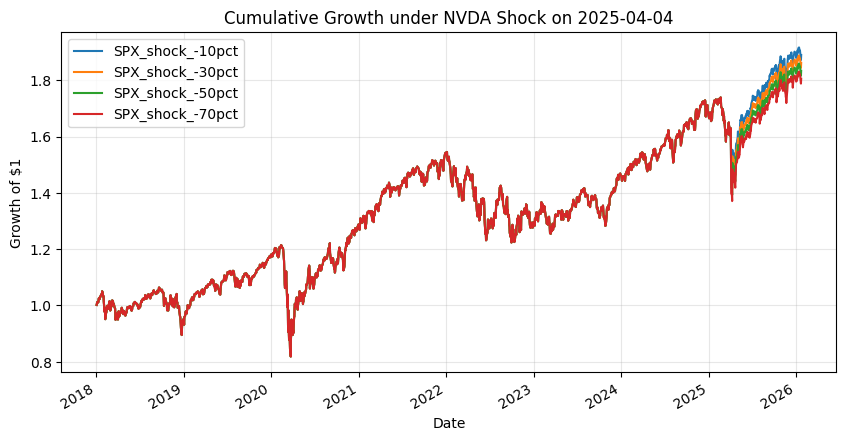

In [10]:
from src.nvda_spx.plotting import plot_cumulative

plot_cumulative(shock_df, title=f"Cumulative Growth under NVDA Shock on {shock_date.date()}");

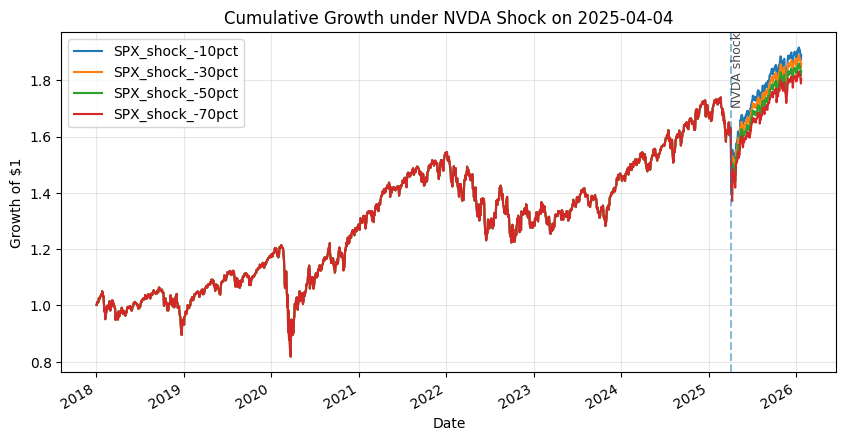

In [11]:
# testing annotations

plot_cumulative(
    shock_df,
    title=f"Cumulative Growth under NVDA Shock on {shock_date.date()}",
    annotations={shock_date: "NVDA shock"},
);

In [12]:
# testing drawdown metrics on shock_df

from src.nvda_spx.metrics import summarize_shock_scenarios

summary = summarize_shock_scenarios(shock_df, shock_date)
summary

,shock_date,pre_shock_level,max_drawdown_date,recovery_date,days_to_recovery,max_drawdown_pct
scenario,,,,,,
SPX_shock_-70pct,2025-04-04,1.559643,2025-04-08,2025-05-12,25,-12.105417
SPX_shock_-50pct,2025-04-04,1.559643,2025-04-08,2025-05-02,19,-10.732678
SPX_shock_-30pct,2025-04-04,1.559643,2025-04-08,2025-04-29,16,-9.359939
SPX_shock_-10pct,2025-04-04,1.559643,2025-04-08,2025-04-24,13,-7.987200
